In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_validate
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut
from sklearn.model_selection import cross_val_score
from sklearn.cross_decomposition import PLSRegression

# add ./utlities/ to path
import sys
sys.path.insert(0, './utilities/')
from MF import *

In [34]:
def get_feature_matrix(masstime, data, significant=True):
    if not significant:
        return data.iloc[3:,8:].to_numpy(dtype=float).T
    inds=[]
    for i in range(3,data.shape[0]):
        mt=data.iloc[i,4] + '@' + data.iloc[i,5]
        if mt in masstime:
            inds.append(i)
    inds=np.unique(np.asarray(inds, dtype=int))
    return data.iloc[inds,8:].to_numpy(dtype=float).T

def get_features(masstime, data, significant=True):
    if not significant:
        return data
    inds=[0,1,2]
    for i in range(3,data.shape[0]):
        mt=data.iloc[i,4] + '@' + data.iloc[i,5]
        if mt in masstime:
            inds.append(i)
    inds=np.unique(np.asarray(inds, dtype=int))
    return data.iloc[inds,:]


def get_ids(data):
    ID=[]
    for line in data.iloc[2,8:]:
        ID.append(line.split('_')[-1].split('.')[0])
    return np.array(ID)

def add_noise(x, magnitude):
    return x + np.random.normal(0,magnitude, x.shape)

def make_oneWay_design(covariates):
    LE = LabelEncoder()
    codes = LE.fit_transform(covariates)
    levels = np.unique(codes)
    k = len(levels)
    n = len(codes)
    
    design = np.zeros((n,k))
    mapping = []
    for j in range(k):
        for i in range(n):
            mapping.append(levels[j])
            design[i,j] = (codes[i]==levels[j])
            
    return design, LE.inverse_transform(levels)

In [35]:
path_s = "../../PARKINSONS/PDproj/cellresults/ttest/withGF/only32/ALPHA0.05FC1.0MINVAR0.125/"
#path_s = "../../PARKINSONS/PDproj/cellresults/ttest/withGF/only32/ALPHA0.05FC1.5MINVAR0.250/"
filenames_s = [line.split('\n')[0] for line in open(path_s + "filenames.txt")]
filenames_s

['cellshilicnegALPHA0.05FC1.0MINVAR0.125.csv',
 'cellshilicposALPHA0.05FC1.0MINVAR0.125.csv',
 'cellslipidnegALPHA0.05FC1.0MINVAR0.125.csv',
 'cellslipidposALPHA0.05FC1.0MINVAR0.125.csv',
 'cellsRPnegALPHA0.05FC1.0MINVAR0.125.csv',
 'cellsRPposALPHA0.05FC1.0MINVAR0.125.csv',
 'mediumhilicnegALPHA0.05FC1.0MINVAR0.125.csv',
 'mediumhilicposALPHA0.05FC1.0MINVAR0.125.csv',
 'mediumRPnegALPHA0.05FC1.0MINVAR0.125.csv',
 'mediumRPposALPHA0.05FC1.0MINVAR0.125.csv']

In [36]:
path = "../../PARKINSONS/PDproj/celldata/datawithGFstatus/clean/"
filenames = [line.split('\n')[0] for line in open(path + "filenames.txt")]
filenames

['cellshilicnegGFstatus.csv',
 'cellshilicposGFstatus.csv',
 'cellslipidnegGFstatus.csv',
 'cellslipidposGFstatus.csv',
 'cellsRPnegGFstatus.csv',
 'cellsRPposGFstatus.csv',
 'mediumhilicnegGFstatus.csv',
 'mediumhilicposGFstatus.csv',
 'mediumRPnegGFstatus.csv',
 'mediumRPposGFstatus.csv']

### Get significant features with GAP status

In [37]:
fnum=1
pathGF = "../../PARKINSONS/PDproj/celldata/datawithGFstatus/clean/"
filenamesGF = [line.split('\n')[0] for line in open(pathGF + "filenames.txt")]
print(filenamesGF[fnum])
data = pd.read_csv(pathGF + filenamesGF[fnum],sep=';', header=None)

path_s = "../../PARKINSONS/PDproj/cellresults/ttest/withGF/only32/ALPHA0.05FC1.0MINVAR0.125/"
filenames_s = [line.split('\n')[0] for line in open(path_s + "filenames.txt")]
print(filenames_s[fnum])
df_significance = pd.read_csv(path_s + filenames_s[fnum],sep=';')

masstime = np.unique(df_significance[' masstime'].to_numpy())
significant_features = get_features(masstime, data, True)
x1 = significant_features.iloc[3:,8:48].to_numpy(dtype=float).T
x_all = data.iloc[3:,8:48].to_numpy(dtype=float).T
ID=get_ids(data.iloc[:,:48])

print("{} significant features".format(len(masstime)))

cellshilicposGFstatus.csv
cellshilicposALPHA0.05FC1.0MINVAR0.125.csv
58 significant features


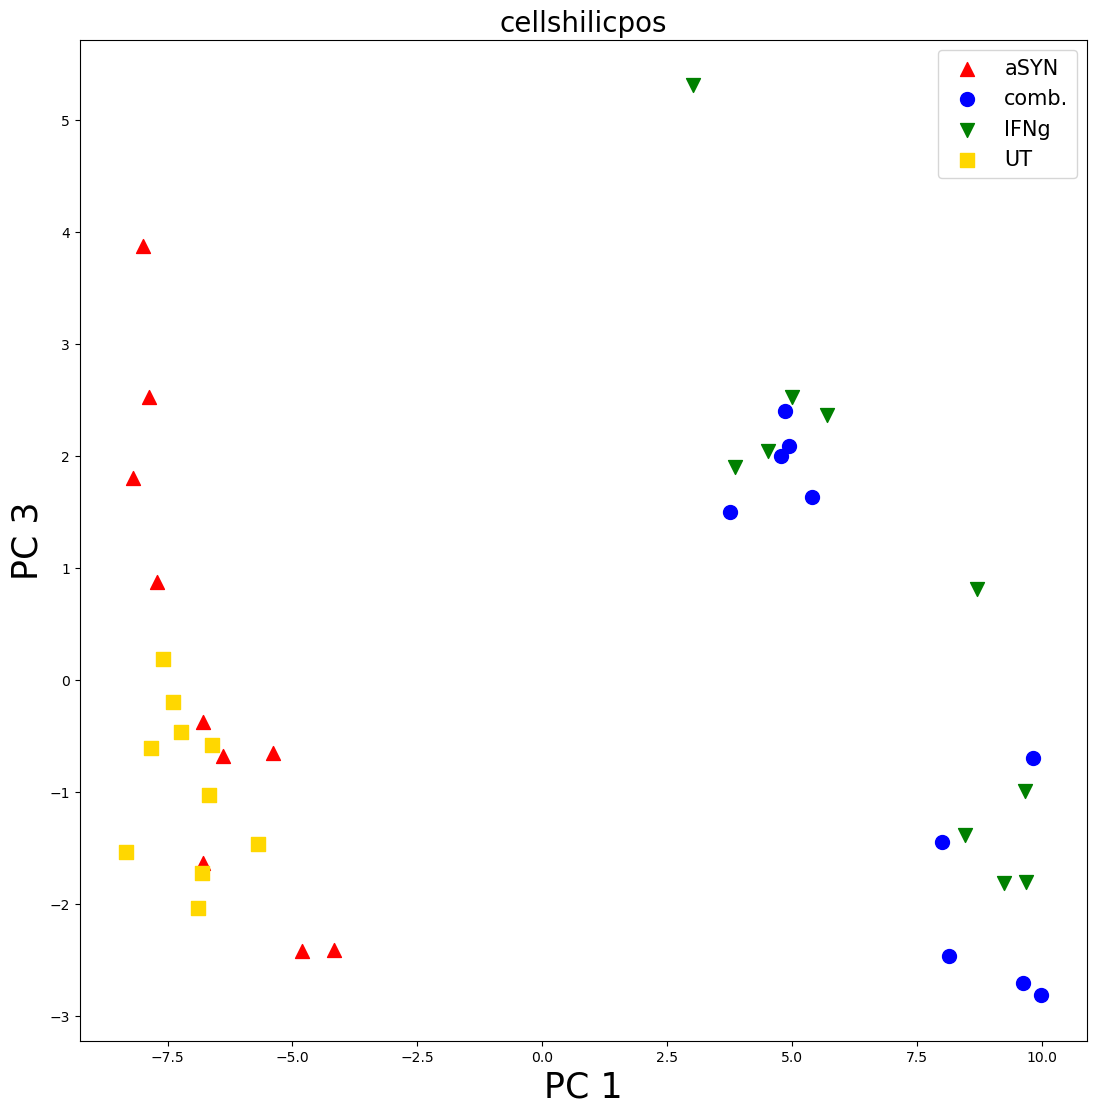

In [38]:
SAVE=False
INCLUDE_ID=False

tle1 = filenamesGF[fnum].split('GF')[0]

pca = PCA().fit_transform(x1)
#pca = add_noise(pca, 1)
assert(x1.shape[0]==40==pca.shape[0])
k=2
fig, ax = plt.subplots(figsize=(13,13))
ax.scatter(pca[:10,0],pca[:10,k], marker='^', c='red', s=100)
ax.scatter(pca[10:20,0],pca[10:20,k], marker='o', c='blue', s=100)
ax.scatter(pca[20:30,0],pca[20:30,k], marker='v', c='green', s=100)
ax.scatter(pca[30:,0],pca[30:,k], marker='s', c='gold', s=100)
ax.legend(['aSYN','comb.','IFNg','UT'], fontsize=15)

if INCLUDE_ID:
    for i, txt in enumerate(ID):
        ax.annotate(txt, (pca[i,0], pca[i,k]),fontsize=12)

plt.xlabel('PC 1', fontsize=25)
plt.ylabel('PC {}'.format(k+1), fontsize=25)
plt.title(tle1, fontsize=20)
plt.show()

if SAVE:
    tle += '_PCA1vs{}'.format(k)
    fig.savefig('../../PDproj/paavo/plots/pca/eps/{}.eps'.format(tle1))
    fig.savefig('../../PDproj/paavo/plots/pca/tifs/{}.tif'.format(tle1))
    fig.savefig('../../PDproj/paavo/plots/pca/jpeg/{}.jpg'.format(tle1))

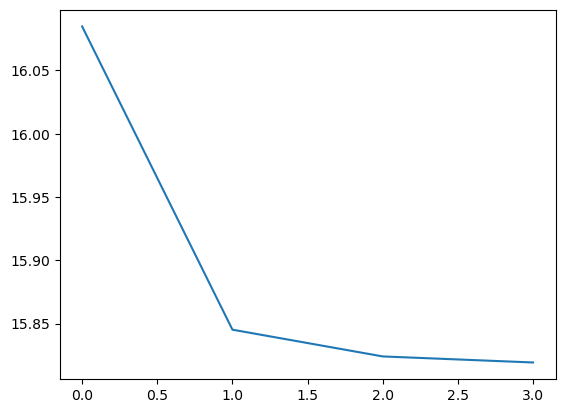

In [40]:
U_init, V_init = nnd_svd_initialization(x1, 4)
U, V, err = matrix_factorization(x1, U_init, V_init, 4, 1000, 0.0001)
plt.plot(err)

### Get data from another mode

In [79]:
x.shape

(40, 58)

In [30]:
fnum2=1
pathGF = "../../PARKINSONS/PDproj/celldata/datawithGFstatus/clean/"
filenamesGF = [line.split('\n')[0] for line in open(pathGF + "filenames.txt")]
print(filenamesGF[fnum2])
data_2 = pd.read_csv(pathGF + filenamesGF[fnum2],sep=';', header=None)

path_s2 = "../../PARKINSONS/PDproj/cellresults/ttest/withGF/only32/ALPHA0.05FC1.0MINVAR0.125/"
filenames_s2 = [line.split('\n')[0] for line in open(path_s2 + "filenames.txt")]
print(filenames_s2[fnum2])
df_significance_2 = pd.read_csv(path_s2 + filenames_s2[fnum2],sep=';')

masstime_2 = np.unique(df_significance_2[' masstime'].to_numpy())
significant_features_2 = get_features(masstime_2, data_2, True)
x2 = significant_features_2.iloc[3:,8:48].to_numpy(dtype=float).T
x_1and2 = np.hstack((x1,x2))

print("{} significant features".format(len(masstime_2)))
print("%i combined significant features" % x_1and2.shape[1])

cellshilicposGFstatus.csv
cellshilicposALPHA0.05FC1.0MINVAR0.125.csv
58 significant features
62 combined significant features


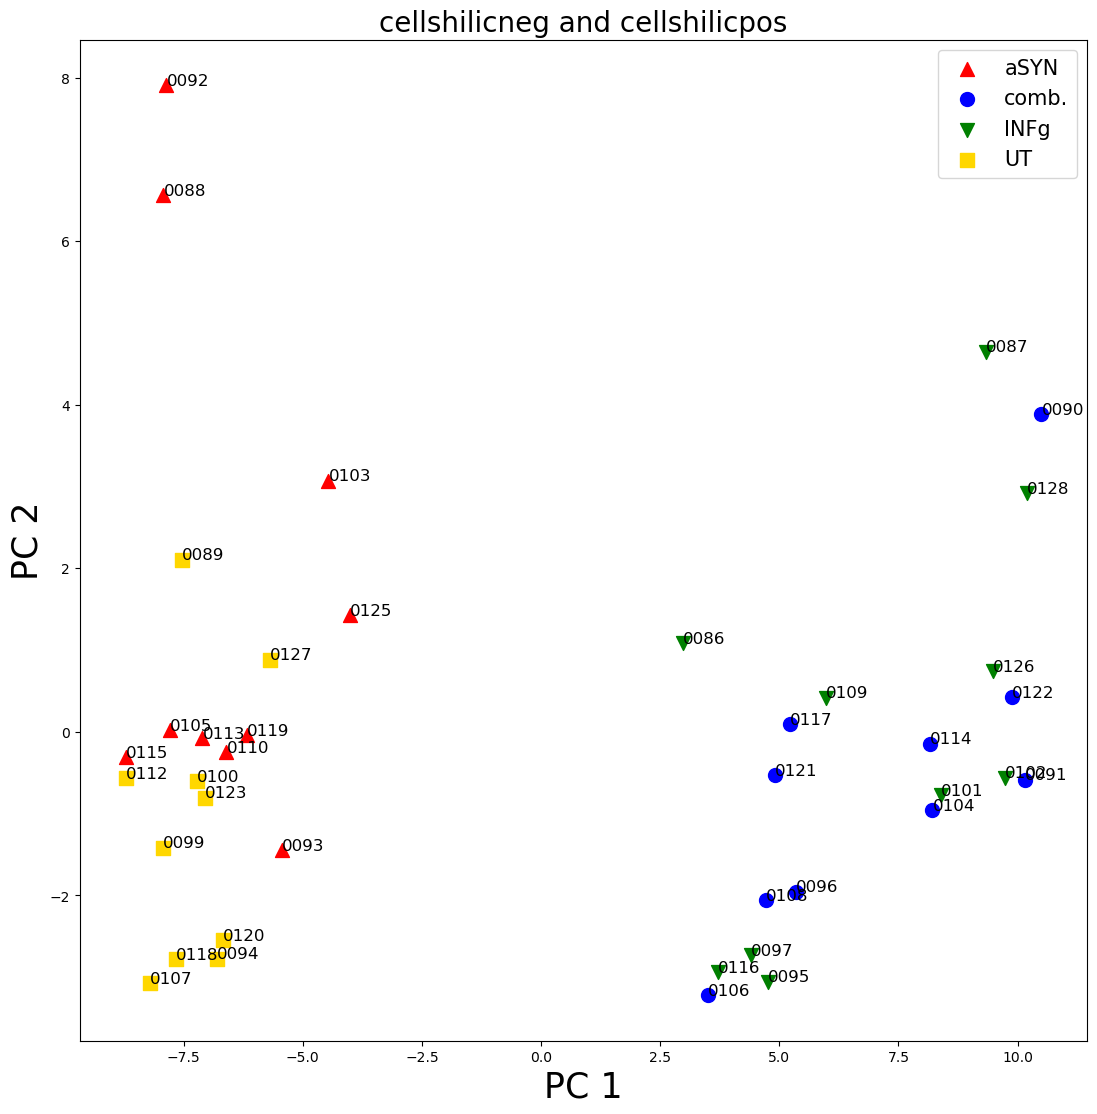

In [25]:
SAVE=False
INCLUDE_ID=False

tle2 = filenamesGF[fnum2].split('GF')[0]


pca = PCA().fit_transform(x_1and2)
#pca = add_noise(pca, 1)

k=1
fig, ax = plt.subplots(figsize=(13,13))
ax.scatter(pca[:10,0],pca[:10,k], marker='^', c='red', s=100)
ax.scatter(pca[10:20,0],pca[10:20,k], marker='o', c='blue', s=100)
ax.scatter(pca[20:30,0],pca[20:30,k], marker='v', c='green', s=100)
ax.scatter(pca[30:,0],pca[30:,k], marker='s', c='gold', s=100)
ax.legend(['aSYN','comb.','INFg','UT'], fontsize=15)

if INCLUDE_ID:
    for i, txt in enumerate(ID):
        ax.annotate(txt, (pca[i,0], pca[i,k]),fontsize=12)

plt.xlabel('PC 1', fontsize=25)
plt.ylabel('PC {}'.format(k+1), fontsize=25)
plt.title(tle1 + ' and ' + tle2, fontsize=20)
plt.show()

if SAVE:
    tle_combined = tle1 + '_and_{}_PCA1vs{}'.format(tle2,k)
    fig.savefig('../../PDproj/paavo/plots/pca/eps/{}.eps'.format(tle_combined))
    fig.savefig('../../PDproj/paavo/plots/pca/tifs/{}.tif'.format(tle_combined))
    fig.savefig('../../PDproj/paavo/plots/pca/jpeg/{}.jpg'.format(tle_combined))

### Check GAP fill patterns

In [ ]:
fnum=0
pathGF = "../../PARKINSONS/PDproj/celldata/datawithGFstatus/clean/"
filenamesGF = [line.split('\n')[0] for line in open(pathGF + "filenames.txt")]
print(filenamesGF[fnum])
data = pd.read_csv(pathGF + filenamesGF[fnum],sep=';', header=None)

path_s = "../../PARKINSONS/PDproj/cellresults/ttest/withGF/only32/ALPHA0.05FC1.0MINVAR0.125/"
filenames_s = [line.split('\n')[0] for line in open(path_s + "filenames.txt")]
print(filenames_s[fnum])
df_significance = pd.read_csv(path_s + filenames_s[fnum],sep=';')

masstime = np.unique(df_significance[' masstime'].to_numpy())
significant_features = get_features(masstime, data, True)
Area = significant_features.iloc[3:,8:48].to_numpy(dtype=float)
Area_all = data.iloc[3:,8:48].to_numpy(dtype=float)
ID=get_ids(data.iloc[:,:48])

GFcols = [i for i in range(0,significant_features.shape[1]) if i not in np.arange(8,88)]
GF=significant_features.iloc[:,GFcols]
gaps = GF.iloc[3:,8:48].to_numpy(dtype=int)
groups = data.iloc[0,8:48]
LE = LabelEncoder()
labels = LE.fit_transform(groups)
print("{} significant features".format(len(masstime)))

In [22]:
aSYN=GF.iloc[:,8:18]
comb=GF.iloc[:,18:28]
INFg=GF.iloc[:,28:38]
UT=GF.iloc[:,38:]

In [23]:
tol=10
token=8
inds=[]
ls=['aSYN','comb','INFg','UT']
for k, group in enumerate([aSYN,comb,INFg,UT]):
    for i in range(3,group.shape[0]):
        arr=np.asarray(group.iloc[i,:], dtype=int)
        s=np.sum(arr==token)
        if s>=tol:
            inds.append((ls[k],i))

### Get significant features by matching masstimes